In [37]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
df = pd.read_csv("train/train.csv")

In [39]:
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


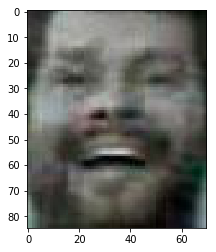

In [40]:
img = plt.imread("train/Train/377.jpg")
plt.imshow(img)

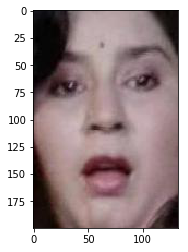

In [41]:
img = plt.imread("train/Train/4487.jpg")
plt.imshow(img)

In [42]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

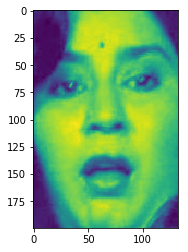

In [43]:
plt.imshow(img_gray)

In [44]:
img_gray.shape

(200, 133)

In [45]:
img.shape

(200, 133, 3)

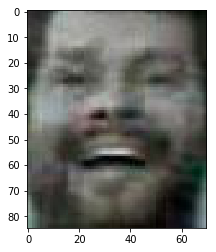

In [46]:
img = plt.imread("train/Train/377.jpg")
plt.imshow(img)

In [47]:
img.shape

(85, 70, 3)

In [48]:
img_gray = cv2.resize(img_gray, (32, 32), interpolation = cv2.INTER_CUBIC)

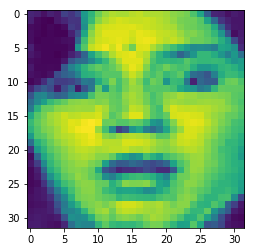

In [49]:
plt.imshow(img_gray)

In [50]:
import glob
print(len(glob.glob('train/Train/*.jpg')))

19906


In [51]:
len(df)

19906

In [52]:
df["Class"].value_counts()

MIDDLE    10804
YOUNG      6706
OLD        2396
Name: Class, dtype: int64

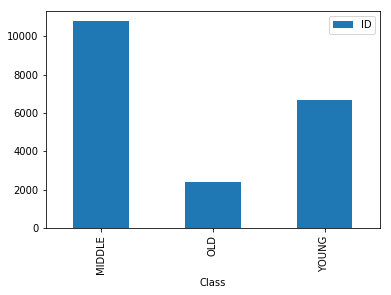

In [53]:
df_class_group = df.groupby("Class").count()
df_class_group.plot(kind="bar")

In [134]:
from keras.models import Sequential
from keras.layers import Lambda, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dropout

In [135]:
from scipy import ndimage

#rotation angle in degree



In [324]:
def processImage(filePath, isRotate = 0):
    img = plt.imread(filePath)
    
    # convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if isRotate == 1:
        rotated = ndimage.rotate(img, 30)
    else:
        if isRotate == 2:
            rotated = ndimage.rotate(img, -45)
    # resize to (32, 32)
    img = cv2.resize(img, (32, 32))
    
    return img

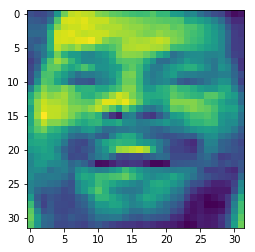

In [325]:
img = processImage("train/Train/377.jpg")
plt.imshow(img)

In [326]:
X_train = []
Y_train = []
for _, row in df.iterrows():
    fileName = row['ID']
    fullFileName = "train/Train/" + fileName
    img = processImage(fullFileName)
    X_train.append(img)
    Y_train.append(row['Class'])
    
    if row["Class"] == "OLD" or row["Class"] == "YOUNG":
        img = processImage(fullFileName, 1)
        X_train.append(img)
        Y_train.append(row['Class'])
        
        img = processImage(fullFileName, 2)
        X_train.append(img)
        Y_train.append(row['Class'])

In [327]:
X_train = np.array(X_train)

In [328]:
X_train.shape

(38110, 32, 32)

In [329]:
X_train = np.reshape(X_train, (-1, 32, 32, 1))

In [330]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y = encoder.transform(Y_train)
dummy_y = np_utils.to_categorical(encoded_Y)

In [331]:
dummy_y[:3]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [403]:
def getModel():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
                    input_shape=(32, 32, 1)))
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
    model.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
    model.add(Dropout(0.20))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(24, (5, 5), activation='relu', padding='same'))
    model.add(Conv2D(24, (5, 5), activation='relu', padding='same'))
    model.add(Dropout(0.20))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
    model.add(Dropout(0.20))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    
    model.add(Flatten())
    model.add(Dense(15, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [404]:
estimator = KerasClassifier(build_fn=getModel, epochs=4, batch_size=32, verbose=2)

In [405]:
estimator.fit(X_train, dummy_y)

Epoch 1/4
22s - loss: 0.7918 - acc: 0.6581
Epoch 2/4
21s - loss: 0.6326 - acc: 0.7372
Epoch 3/4
24s - loss: 0.5352 - acc: 0.7793
Epoch 4/4
24s - loss: 0.4645 - acc: 0.8089


In [406]:
df_test = pd.read_csv("test/test.csv")

In [407]:
df_test.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [408]:
len(df_test)

6636

In [409]:
df.iloc[0]

ID       377.jpg
Class     MIDDLE
Name: 0, dtype: object

In [410]:
X_test = []
for _, row in df_test.iterrows():
    fileName = row['ID']
    fullFileName = "test/Test/" + fileName
    img = processImage(fullFileName)
    X_test.append(img)

In [411]:
X_test = np.array(X_test)

In [412]:
X_test = np.reshape(X_test, (-1, 32, 32, 1))

In [413]:
Y_test = estimator.predict(X_test)

In [414]:
Y_test.shape

(6636,)

In [415]:
Y_test[111]

2

In [416]:
Y_out = encoder.inverse_transform(Y_test)

In [417]:
len(Y_out)

6636

In [418]:
Y_out

array(['MIDDLE', 'YOUNG', 'MIDDLE', ..., 'OLD', 'MIDDLE', 'YOUNG'], 
      dtype='<U6')

In [419]:
df_out = pd.DataFrame()

In [420]:
df_out["Class"] = Y_out
df_out["ID"] = df_test["ID"]
df_out.head()

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,MIDDLE,19277.jpg
3,YOUNG,13093.jpg
4,OLD,5367.jpg


In [421]:
df_out.to_csv("out.csv", index = False)